<table style='border: none' align='left'>
   <tr style='border: none'>
      <th style='border: none'><font face='verdana' size='5' color='black'><b>Train model on Watson Studio Cloud and deploy on Cloud Pak for Data 3.0</b></th>
      <th style='border: none'><img src='https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true' alt='Watson Machine Learning icon' height='40' width='40'></th>
   </tr>
   <tr style='border: none'>
       <th style='border: none'><img src='https://github.com/pmservice/wml-sample-models/raw/master/scikit-learn/hand-written-digits-recognition/images/numbers_banner-04.png' width='600' alt='Icon'> </th>
   </tr>
</table>

This notebook demonstrates how to utilize the <a href="https://pypi.python.org/pypi/watson-machine-learning-client-V4" target="_blank" rel="noopener noreferrer">watson-machine-learning-client-V4</a> package in order to save the model on **Watson Studio Cloud**, download it, and deploy it on **CP4D 3.0**.

Some familiarity with Python is helpful. This notebook uses Python 3.6, scikit-learn, and the Watson Machine Learning (WML) API client (`watson-machine-learning-client-V4`).

You will use the sample data set of hand-written digit images, **sklearn.datasets.load_digits**, which is available in scikit-learn to recognize hand-written digits.

## Learning goals

In this notebook, you will learn how to:

-  Load a sample data set from ``scikit-learn``.
-  Explore data.
-  Split data for training and evaluation.
-  Create a scikit-learn machine learning pipeline.
-  Train and evaluate a model.
-  Store the model in the Watson Machine Learning (WML) repository.
-  Download the model as a `tar.gz` file.
-  Save the model in a deployment space on CP4D.
-  Deploy the model for online scoring in the deployment space.
-  Score test records.


## Contents

- [Set up the environment](#setup)
- [Creating the model on Watson Studio Cloud](#wscloud)
    1. [Load and explore data](#load)
    2. [Create a scikit-learn model](#model)
    3. [Download the model (without WML)](#download)
    4. [Save the model in the WML repository](#savemodel)
- [Deploy the model on CP4D 3.0](#cp4d)
    1. [Setting up](#setupcp4d)
    1. [Save the model in a deployment space](#savetospace)
    2. [Deploy to the deployment space and score data](#scoring)
- [Summary and next steps](#summary)

<a id='setup'></a>
## Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  To use Watson Machine Learning on **Watson Studio Cloud**, create a <a href="https://cloud.ibm.com/catalog/services/machine-learning" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener no referrer">here</a>)<br><br>

- To get started on **CP4D 3.0**, find documentation on installation and set up <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/cpd/overview/welcome.html" target="_blank" rel="noopener no referrer">here</a>.<br><br>

- Configure your local python environment:
  + python 3.6
  + scikit-learn 0.20
  + watson-machine-learning-client

# Creating the model on Watson Studio Cloud <a id="wscloud"></a>

<a id='load'></a>
## 1. Load and explore data

In this section, you will load the data from scikit-learn sample data sets and perform basic exploratory data analysis (EDA).

In [1]:
!pip install scikit-learn==0.20.3

In [2]:
# Load the data.
import sklearn
from sklearn import datasets

# Description of the Digits Data set.
digits = datasets.load_digits()
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each bloc

The sample data set consists of 8x8 pixel images of hand-written digits.

In [3]:
digits.data.shape

(1797, 64)

Display the first digit data and label using **data** and **target**. The hand-written digit shown below is an 8x8 pixel image represented by an array.

In [4]:
print(digits.data[0].reshape((8, 8)))

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


In [5]:
digits.target[0]

0

In [6]:
import matplotlib.pyplot as plt
import numpy as np

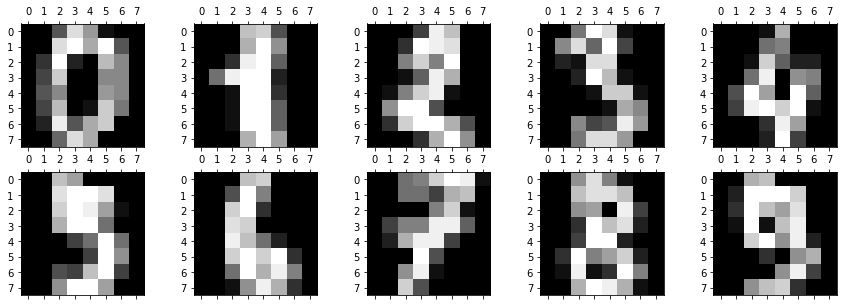

In [7]:
# Visualize some digits from the data set.
f, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(15,5))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

for i in range (len(ax)):
    plt.gray()
    ax[i].matshow(digits.images[i])

In [8]:
# Labels for the written digits displayed above.
digits.target[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In the next step, count the data examples.

In [9]:
# Calculate the number of samples.
samples_count = len(digits.images)

print('Number of samples: ' + str(samples_count))

Number of samples: 1797


<a id='model'></a>
## 2. Create a scikit-learn model

In this section you learn how to:
- [2.1 Split data](#prep)
- [2.2 Create a scikit-learn machine learning pipeline](#pipe)
- [2.3 Train a model](#train)

### 2.1 Split data<a id='prep'></a>

In this subsection you will split your data into: 
- Train data set
- Test data set
- Score data sets

In [10]:
# Split the data into data sets and display the number of records for each data set.
train_data = digits.data[: int(0.7*samples_count)]
train_labels = digits.target[: int(0.7*samples_count)]

test_data = digits.data[int(0.7*samples_count): int(0.9*samples_count)]
test_labels = digits.target[int(0.7*samples_count): int(0.9*samples_count)]

score_data = digits.data[int(0.9*samples_count): ]

print('Number of training records: ' + str(len(train_data)))
print('Number of testing records : ' + str(len(test_data)))
print('Number of scoring records : ' + str(len(score_data)))

Number of training records: 1257
Number of testing records : 360
Number of scoring records : 180


Your data has been successfully split into three data sets: 

-  The train data set, which is the largest group, is used for training.
-  The test data set will be used for model evaluation and is used to test the assumptions of the model.
-  The score data set will be used for scoring in Cloud.

### 2.2 Create a scikit-learn machine learning pipeline<a id='pipe'></a>

In this section, you will create a scikit-learn machine learning pipeline and then train the model.

First, import the scikit-learn machine learning modules that are needed in the subsequent steps.

In [11]:
# Import scikit-learn packages.
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn import svm, metrics

Standardize the features by removing the mean and scaling to unit variance.

In [12]:
scaler = preprocessing.StandardScaler()

Next, define the estimators you want to use for classification. The following example uses Support Vector Machines (SVM) with the radial basis function (used for non-linear data) as kernel.

In [13]:
clf = svm.SVC(kernel='rbf', gamma='auto')

Build the pipeline. A pipeline consists of transformer and an estimator.

In [14]:
pipeline = Pipeline([('scaler', scaler), ('svc', clf)])

### 2.3 Train a model<a id='train'></a>

Now, you can use the **pipeline** and **train data** you defined previously to train your SVM model.

In [15]:
model = pipeline.fit(train_data, train_labels)

Use **test data** to generate an evaluation report to check your **model quality**.

In [16]:
# Evaluate your model.
predicted = model.predict(test_data)

print('Evaluation report: \n\n%s' % metrics.classification_report(test_labels, predicted))

Evaluation report: 

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        37
           1       0.97      0.97      0.97        34
           2       1.00      0.97      0.99        36
           3       1.00      0.94      0.97        35
           4       0.78      0.97      0.87        37
           5       0.97      0.97      0.97        38
           6       0.97      0.86      0.91        36
           7       0.92      0.97      0.94        35
           8       0.91      0.89      0.90        35
           9       0.97      0.92      0.94        37

   micro avg       0.94      0.94      0.94       360
   macro avg       0.95      0.94      0.95       360
weighted avg       0.95      0.94      0.95       360



**Note:** You can tune your model or try creating classification models to achieve better accuracy. For simplicity of this example, the tuning section and model selection are omitted.

<div class="alert alert-block alert-info">
    If you would like to download the model at this step <b><i>without</i> using Watson Machine Learning</b>, please run the next few lines of code and then skip to the CP4D section in the notebook. <br> If you'd like to save the model in the <b>Watson Machine Learning Repository</b> on Watson Studio Cloud, you can skip to <b><a href=#savemodel>Section 4: Save the model in the WML repository</a></b>.</div>

## 3. Download the model (without WML) <a id="download"></a>

In [17]:
#Save the model file
import pickle
filename = "sklearn_pipeline.pkl"
with open(filename, 'wb') as file:
    pickle.dump(model, file)

Compress the model into a `.tar.gz` file. You can see that the compressed model, as well as the original file, are saved in the file system.

In [18]:
!tar -zcvf digits_prediction_model.tar.gz sklearn_pipeline.pkl

sklearn_pipeline.pkl


In [19]:
!ls

digits_prediction_model.tar.gz	     sklearn_pipeline.pkl
digits_prediction_model_test.tar.gz


Create a download link for the compressed model file. You can click on this link to download the file onto your local machine.

In [20]:
# creates download link for binary files on notebook filesystem
def create_download_link(file_path, title="Download file"):
    from IPython.display import HTML
    import base64, os
    
    # open model file
    filename = os.path.basename(file_path)
    with open(file_path, 'rb') as file:
        model_file = file.read()
    
    # convert data from the binary file
    b64 = base64.b64encode(model_file)
    payload = b64.decode()
    
    # write HTML for download link
    html = '<a download="{filename}" href="data:binary;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload, title=title, filename=filename)
    return HTML(html)

In [21]:
create_download_link("digits_prediction_model.tar.gz")

You can now head the step: [Deploy the model on CP4D 3.0](#cp4d) to manage your downloaded model on CP4D.

<a id='savemodel'></a>
## 4. Save the model in the WML repository

In this section, you will learn how to use the `watson-machine-learning-client-V4` package to manage your model in the WML repository.

- [4.1 Set up the WML instance](#work)
- [4.2 Save the model in the WML repository](#save)
- [4.3 Delete a model from the WML repository](#delete)

### 4.1 Set up the WML instance<a id='work'></a>

Import the `watson-machine-learning-client` module.
<div class="alert alert-block alert-info">
For more information about the <b>Watson Machine Learning Python client (V4)</b>, please refer to the <a href="https://wml-api-pyclient-dev-v4.mybluemix.net/" target="_blank" rel="noopener no referrer">Python client documentation</a>.
</div>

In [22]:
!pip install --upgrade watson-machine-learning-client-V4==1.0.70

Requirement already up-to-date: watson-machine-learning-client-V4==1.0.70 in /opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages (1.0.70)


**Tip**: Authentication information (your credentials) can be found in the <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-get-wml-credentials.html" target="_blank" rel="noopener no referrer">Service credentials</a> tab of the service instance that you created on the IBM Cloud. <BR>If you cannot find the **instance_id** field in **Service Credentials**, click **New credential (+)** to generate new authentication information. 

**Action**: Enter your Watson Machine Learning service instance credentials here.

In [23]:
wml_credentials = {
    "apikey": "---",
    "instance_id": "---",
    "url": "https://us-south.ml.cloud.ibm.com"
}

In [24]:
# The code was removed by Watson Studio for sharing.

In [25]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

#### Instantiate the WML Python client object. 

In [26]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [27]:
client.version

'1.0.70'

### 4.2 Save the model in the WML repository<a id='save'></a>

Define the model name when saving the model in the WML repository.

In [28]:
# Model Metadata.
meta_props={
    client.repository.ModelMetaNames.NAME: "Digits prediction model",
    client.repository.ModelMetaNames.RUNTIME_UID: "scikit-learn_0.20-py3.6",
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.20",
}

In [29]:
# Create the model artifact.
model_artifact = client.repository.store_model(model,
                                                   meta_props=meta_props,
                                                   training_data=train_data,
                                                   training_target=train_labels)
model_uid = client.repository.get_model_uid(model_artifact)
print("Model UID = " + model_uid)

Model UID = 087ae94c-0aea-4b98-81f6-868aab53179f


#### Get information about a specific model in the WML repository.

In [30]:
# Details about the model.
model_details = client.repository.get_details(model_uid)
print(model_details)

{'metadata': {'name': 'Digits prediction model', 'guid': '087ae94c-0aea-4b98-81f6-868aab53179f', 'rev': 'adc384ed-4dd1-4262-9cfc-b2a18f10403a', 'id': '087ae94c-0aea-4b98-81f6-868aab53179f', 'modified_at': '2020-05-29T20:05:25.681Z', 'created_at': '2020-05-29T20:05:25.624Z', 'href': '/v4/models/087ae94c-0aea-4b98-81f6-868aab53179f?rev=adc384ed-4dd1-4262-9cfc-b2a18f10403a'}, 'entity': {'name': 'Digits prediction model', 'training_data_references': [{'location': {'bucket': 'not_applicable'}, 'type': 's3', 'connection': {'access_key_id': 'not_applicable', 'secret_access_key': 'not_applicable', 'endpoint_url': 'not_applicable'}, 'schema': {'id': '1', 'type': 'ndarray', 'fields': [{'name': 'f0', 'type': 'float'}, {'name': 'f1', 'type': 'float'}, {'name': 'f2', 'type': 'float'}, {'name': 'f3', 'type': 'float'}, {'name': 'f4', 'type': 'float'}, {'name': 'f5', 'type': 'float'}, {'name': 'f6', 'type': 'float'}, {'name': 'f7', 'type': 'float'}, {'name': 'f8', 'type': 'float'}, {'name': 'f9', 'typ

#### Get information of all the models in the WML repository.

In [31]:
# Display a list of all the models.
client.repository.list_models()

------------------------------------  --------------------------------------------------------------------------  ------------------------  -----------------
GUID                                  NAME                                                                        CREATED                   TYPE
087ae94c-0aea-4b98-81f6-868aab53179f  Digits prediction model                                                     2020-05-29T20:05:25.624Z  scikit-learn_0.20
76dce5b2-ef9a-442d-b573-1c926a733b62  Digits prediction model                                                     2020-05-29T20:03:48.668Z  scikit-learn_0.20
b9ec3c4f-ee6e-47c6-b175-a48511ab2b94  Fashion MNIST GAN model                                                     2020-05-15T00:44:52.408Z  keras_2.2.5
40f743f4-4587-446b-9631-b06ad9f0d17f  Credit Risk Deployment AutoAI Model                                         2020-05-14T06:07:11.700Z  wml-hybrid_0.1
cd15045e-1e05-491f-8dc4-78b48732b3a1  Custom ARIMA estimator for sklearn p

<div class="alert alert-block alert-info">
    You can see that the model was successfully saved in the Watson Machine Learning repository.
</div>

In [32]:
client.repository.download(model_uid, 'digits_prediction_model_test_2.tar.gz')

Successfully saved model content to file: 'digits_prediction_model_test_2.tar.gz'


'/home/wsuser/work/digits_prediction_model_test_2.tar.gz'

In [33]:
from watson_machine_learning_client.utils import create_download_link

create_download_link("digits_prediction_model.tar.gz")

Click on the link above to download the model you just saved in the Watson Machine Learning repository on Watson Studio Cloud.

### 4.3 Delete a model from the WML repository<a id='delete'></a>

You can use the code in the following cell to delete a published model from the WML repository.

In [34]:
# client.repository.delete(model_uid)

# Deploy the model on CP4D 3.0 <a id="cp4d"></a>

**Action:** Upload the model `tar.gz` (downloaded in the previous section) to the CP4D project you're working on. You can do that by clicking on the data icon in the upper right corner of this page and dropping the model `tar.gz` file. Make sure you reload the notebook to ensure the model appears.

## 1. Setting up <a id="setupcp4d"></a>

Import the `watson-machine-learning-client` module.
<div class="alert alert-block alert-info">
For more information about the <b>Watson Machine Learning Python client (V4)</b>, please refer to the <a href="https://wml-api-pyclient-dev-v4.mybluemix.net/" target="_blank" rel="noopener no referrer">Python client documentation</a>. If you're using the notebook within a project on your CP4D cluster, you do not need to install this package as it comes pre-installed with the notebooks. The installation code below is for demonstration but is non-executable at this stage.
</div>

In [35]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

**Authenticate the Python client on CP4D.**<br><br>

<div class="alert alert-block alert-info">
    To find your authentication information (your credentials) follow the steps provided here in the <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/analyze-data/ml-authentication-local.html" target="_blank" rel="noopener no referrer">Documentation</a>.
</div>

**Action**: Enter your credentials in the following cell.

In [36]:
# Enter your credentials here.

from project_lib.utils import environment
url = environment.get_common_api_url()

import sys,os,os.path
token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
     "instance_id": "openshift",
     "token": token,
     "url": url,
     "version": "3.0.0"
}

In [37]:
client = WatsonMachineLearningAPIClient(wml_credentials)

You can obtain the space UID using the following cells.

<div class="alert alert-block alert-info">
    You can create your own <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/analyze-data/ml-spaces_local.html" target="_blank" rel="noopener no referrer">deployment space</a> by selecting <b>Analytics deployments</b> under <b>Analyze</b> from the Navigation Menu on the top left of this page.
</div>

Alternatively, you can create a deployment using the code in the following cell. The cell is not executable cell at this stage, but you can enter the name of your space in the metadata and use it if needed.

In [38]:
# Obtain the UId of your space
def guid_from_space_name(client, space_name):
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['guid'])

**Action:** Enter the name of your deployment space in the code below: `space_uid = guid_from_space_name(client, 'YOUR DEPLOYMENT SPACE')`.

In [39]:
# Enter the name of your deployment space here:
space_uid = guid_from_space_name(client, 'YOUR DEPLOYMENT SPACE')
print("Space UID = " + space_uid)

Space UID = 75dea37e-f1ee-4a58-9959-5f05c98c2a4d


Setting the default space is mandatory for CP4D. You can set this using the cell below.

In [40]:
client.set.default_space(space_uid)

'SUCCESS'

## 2. Save the model in a deployment space <a id="savetospace"></a>

In this section, you'll learn how to
- 2.1 [Save the model](#savecp4d)
- 2.2 [Load the model](#load_model)

Obtain the training and test data used when saving and testing the model.

In [41]:
!pip install scikit-learn==0.20.3

In [42]:
# Load the data.
import sklearn
from sklearn import datasets

# Description of the Digits Data set.
digits = datasets.load_digits()

# Calculate the number of samples.
samples_count = len(digits.images)

# Split the data into data sets and display the number of records for each data set.
train_data = digits.data[: int(0.7*samples_count)]
train_labels = digits.target[: int(0.7*samples_count)]

test_data = digits.data[int(0.7*samples_count): int(0.9*samples_count)]
test_labels = digits.target[int(0.7*samples_count): int(0.9*samples_count)]

score_data = digits.data[int(0.9*samples_count): ]

### 2.1 Save the model <a id="savecp4d"></a>

Create the model metadata.

In [43]:
# Model Metadata.
software_spec_uid = client.software_specifications.get_uid_by_name('scikit-learn_0.20-py3.6')

meta_props_cp4d={
    client.repository.ModelMetaNames.NAME: "Digits prediction model",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.20",
}

<div class="alert alert-block alert-info">To list the supported software specifications, run <tt>client.software_specifications.list()</tt>.<br>To find more information about the frameworks with their respective <b>Types</b> and <b>Software Specifications</b>, visit the <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/wmls/wmls-deploy-python-types.html" target="_blank" rel="noopener no referrer">documentation</a>.</div>

You need the model UID to create the deployment. You can extract the model UID from the saved model details and use it in the next section to create the deployment.

**Note:** Ensure that you've uploaded the model `tar.gz` file to the project before running the following code.

In [48]:
# Create the model artifact.
model_artifact = client.repository.store_model("/home/wsuser/work/digits_prediction_model_test_2.tar.gz",
                                                   meta_props=meta_props_cp4d,
                                                   training_data=train_data,
                                                   training_target=train_labels)
cp4d_model_uid = client.repository.get_model_uid(model_artifact)
print("Model UID = " + cp4d_model_uid)

Model UID = 22ec2426-1417-4cf2-9967-b29939c76b53


Get the saved model metadata.

In [49]:
model_artifact

{'metadata': {'name': 'Digits prediction model',
  'guid': '22ec2426-1417-4cf2-9967-b29939c76b53',
  'id': '22ec2426-1417-4cf2-9967-b29939c76b53',
  'modified_at': '2020-05-29T20:18:08.002Z',
  'created_at': '2020-05-29T20:18:07.002Z',
  'owner': '1000330999',
  'href': '/v4/models/22ec2426-1417-4cf2-9967-b29939c76b53?space_id=75dea37e-f1ee-4a58-9959-5f05c98c2a4d',
  'space_id': '75dea37e-f1ee-4a58-9959-5f05c98c2a4d'},
 'entity': {'name': 'Digits prediction model',
  'content_status': {'state': 'persisted'},
  'software_spec': {'id': '09c5a1d0-9c1e-4473-a344-eb7b665ff687'},
  'space': {'id': '75dea37e-f1ee-4a58-9959-5f05c98c2a4d',
   'href': '/v4/spaces/75dea37e-f1ee-4a58-9959-5f05c98c2a4d'},
  'type': 'scikit-learn_0.20'}}

List all the saved models.

In [50]:
# Display a list of all the models.
models_details = client.repository.list_models()

------------------------------------  -----------------------  ------------------------  -----------------
GUID                                  NAME                     CREATED                   TYPE
22ec2426-1417-4cf2-9967-b29939c76b53  Digits prediction model  2020-05-29T20:18:07.002Z  scikit-learn_0.20
------------------------------------  -----------------------  ------------------------  -----------------


<div class="alert alert-block alert-info">
    From the list of stored models, you can see that the model is successfully saved in your deployment space. You can view your model by selecting <b>Analytics deployments</b> under <b>Analyze</b> from the Navigation Menu and clicking on your deployment space name.
</div>

### 2.2 Load the model<a id='load_model'></a>

In this subsection, you will learn how to load a saved model.

In [51]:
loaded_model = client.repository.load(cp4d_model_uid)

Make test predictions to check that the model has been loaded correctly.

In [52]:
test_predictions = loaded_model.predict(test_data[:10])

In [53]:
# The predictions made by the model.
print(test_predictions)

[4 0 5 3 6 9 6 4 7 5]


In [54]:
import matplotlib.pyplot as plt
import numpy as np

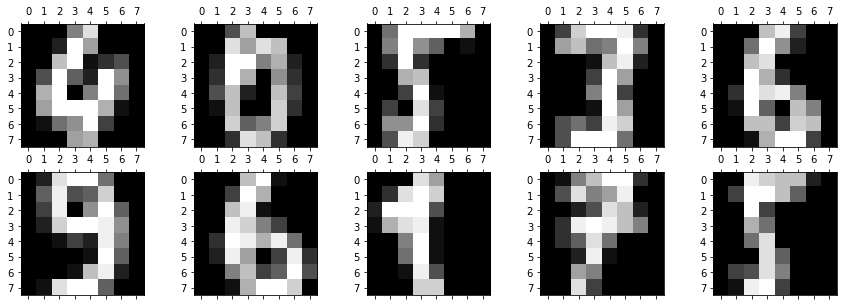

In [55]:
# Visualize the test set images used for the prediction.
f, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(15,5))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

for i in range (len(ax)):
    plt.gray()
    ax[i].matshow(test_data[i].reshape((8, 8)))

In [56]:
# The correct labels for the digits above.
test_labels[:10]

array([4, 0, 5, 3, 6, 9, 6, 1, 7, 5])

As you can see, you are able to make predictions which means that the model has loaded correctly. You have now learned how save and load the model.

<a id='scoring'></a>
## 3. Deploy to the deployment space and score data

In this section, you will learn how to use the WML Python client to perform online scoring and score a test data record.

- [3.1 Create an online deployment for the published model](#create)
- [3.2 Score data](#score)
- [3.3 Delete the deployment](#deldeploy)
- [3.4 Delete the model](#delmodel)


### 3.1 Create an online deployment for the published model<a id='create'></a>

Now, you can create a deployment, *Deployment of scikit handwritten digits model*.

In [57]:
# Deployment metadata.
deploy_meta = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of scikit handwritten digits model",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

In [58]:
# Create the deployment.
deploy_details = client.deployments.create(cp4d_model_uid, meta_props=deploy_meta)



#######################################################################################

Synchronous deployment creation for uid: '22ec2426-1417-4cf2-9967-b29939c76b53' started

#######################################################################################


initializing...........................
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='b895ed75-047d-4fb9-b5b0-d7fe9c38897b'
------------------------------------------------------------------------------------------------




In [59]:
# List the deployments.
client.deployments.list()

------------------------------------  ---------------------------------------------  -----  ------------------------  -------------
GUID                                  NAME                                           STATE  CREATED                   ARTIFACT_TYPE
b895ed75-047d-4fb9-b5b0-d7fe9c38897b  Deployment of scikit handwritten digits model  ready  2020-05-29T20:18:15.525Z  model
------------------------------------  ---------------------------------------------  -----  ------------------------  -------------


<div class="alert alert-block alert-info">
    From the list of deployments, you can see that the model has been successfully deployed to your deployment space.
</div>

You can get the `deployment_uid` by parsing the deployment details.

In [60]:
# Deployment UID.
deployment_uid = client.deployments.get_uid(deploy_details)
print('Deployment uid = {}'.format(deployment_uid))

Deployment uid = b895ed75-047d-4fb9-b5b0-d7fe9c38897b


In [61]:
deploy_details

{'entity': {'asset': {'href': '/v4/models/22ec2426-1417-4cf2-9967-b29939c76b53?space_id=75dea37e-f1ee-4a58-9959-5f05c98c2a4d',
   'id': '22ec2426-1417-4cf2-9967-b29939c76b53'},
  'custom': {},
  'description': '',
  'name': 'Deployment of scikit handwritten digits model',
  'online': {},
  'space': {'href': '/v4/spaces/75dea37e-f1ee-4a58-9959-5f05c98c2a4d',
   'id': '75dea37e-f1ee-4a58-9959-5f05c98c2a4d'},
  'space_id': '75dea37e-f1ee-4a58-9959-5f05c98c2a4d',
  'status': {'online_url': {'url': 'https://internal-nginx-svc:12443/v4/deployments/b895ed75-047d-4fb9-b5b0-d7fe9c38897b/predictions'},
   'state': 'ready'}},
 'metadata': {'created_at': '2020-05-29T20:18:15.525Z',
  'description': '',
  'guid': 'b895ed75-047d-4fb9-b5b0-d7fe9c38897b',
  'href': '/v4/deployments/b895ed75-047d-4fb9-b5b0-d7fe9c38897b',
  'id': 'b895ed75-047d-4fb9-b5b0-d7fe9c38897b',
  'modified_at': '2020-05-29T20:18:15.525Z',
  'name': 'Deployment of scikit handwritten digits model',
  'parent': {'href': ''},
  'spa

### 3.2 Score data<a id='score'></a>

Use the following method to run a test scoring request against the deployed model.

Prepare scoring payload with the records to score.

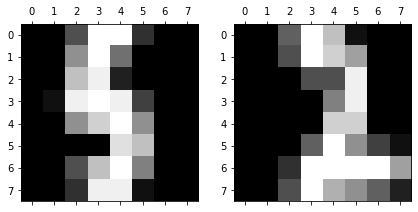

In [62]:
# Prepare scoring payload.
job_payload = {
    client.deployments.ScoringMetaNames.INPUT_DATA: [{
        'values': [list(score_data[0]), list(score_data[1])]
    }]
}

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,4))
ax = [ax1, ax2]

for i in range (len(ax)):
    plt.gray()
    ax[i].matshow(np.array(job_payload['input_data'][0]['values'][i]).reshape((8, 8)))

Use the ``client.deployments.score()`` method to run the scoring.

In [63]:
# Perform prediction and display the result.
job_details = client.deployments.score(deployment_uid,job_payload)
print(job_details)

{'predictions': [{'fields': ['prediction'], 'values': [[5], [2]]}]}


The model predicted the numbers `5` and `2` respectively.

In [64]:
digits.target[int(0.9*samples_count):int(0.9*samples_count)+2]

array([5, 2])

As you can see the model has successfully predicted the values.

### 3.3 Delete the deployment<a id='deldeploy'></a>

If you want to delete the deployment, use the following method.

In [65]:
# client.deployments.delete(deployment_uid)

You can check that your deployment was deleted by generating a list of your saved deployments:

In [66]:
# client.deployments.list()

### 3.4 Delete the model<a id='delmodel'></a>

If you want to delete the model, use the following method.

In [67]:
# client.repository.delete(cp4d_model_uid)

You can check that your model was deleted by generating a list of your saved models:

In [68]:
# client.repository.list_models()

<a id='summary'></a>
# Summary and next steps     

You successfully completed this notebook! 
 
You learned how to use the Watson Machine Learning Python client to save a scikit-learn model on Watson Studio Cloud, download it, and deploy it on CP4D 3.0. 

Check out our <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener noreferrer">Online Documentation</a> for more samples, tutorials, documentation, how-tos, and blog posts on Watson Studio Cloud. 

### Resources <a id="resources"></a>

To learn more about configurations used in this notebook or more sample notebooks, tutorials, documentation, how-tos, and blog posts, check out these links:

<div class="alert alert-block alert-success"><a id="resources"></a>

<h4>IBM documentation</h4>
<br>
 <li> <a href="https://wml-api-pyclient-dev-v4.mybluemix.net" target="_blank" rel="noopener no referrer">watson-machine-learning</a></li> 
 <li> <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/cpd/overview/welcome.html" target="_blank" rel="noopener noreferrer">CP4D 3.0</a></li>
 
<h4> IBM Samples</h4>
<br>
 <li> <a href="https://github.com/IBMDataScience/sample-notebooks" target="_blank" rel="noopener noreferrer">Sample notebooks</a></li>
 
<h4> Others</h4>
<br>
 <li> <a href="https://www.python.org" target="_blank" rel="noopener noreferrer">Official Python website</a></li>
 <li> <a href="https://matplotlib.org" target="_blank" rel="noopener noreferrer">Matplotlib: Python plotting</a></li>
 <li> <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html" target="_blank" rel="noopener noreferrer">scikit-learn: Grid Search</a></li>
 </div>

### Authors

**Wojciech Sobala** is a Data Scientist at IBM developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.  
**Ananya Kaushik** is a Data Scientist at IBM.

<hr>Copyright © 2017-2020 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style='background:#F5F7FA; height:110px; padding: 2em; font-size:14px;'>
<span style='font-size:18px;color:#152935;'>Love this notebook? </span>
<span style='font-size:15px;color:#152935;float:right;margin-right:40px;'>Don't have an account yet?</span><br>
<span style='color:#5A6872;'>Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style='border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;'><a href='https://ibm.co/wsnotebooks' target='_blank' style='color: #3d70b2;text-decoration: none;'>Sign Up</a></span><br>
</div>